# Анализ продаж магазинов

**Описание значений параметров датасета**

* Store ID - (индекс) ID конкретного магазина.
* Store_Area - Физическая площадь магазина в квадратных ярдах.
* Items_Available - Количество различных товаров, доступных в соответствующем магазине.
* DailyCustomerCount - Количество покупателей, посетивших магазин в среднем за месяц.
* Store_Sales - Продажи в (US $), которые совершили магазины.


# Подключение используемых библиотек и загрузка данных

## Подключение библиотек

In [41]:
# preprocessing 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# visualization 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# datasets, classifiers and performance metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, metrics, decomposition
from sklearn.metrics import confusion_matrix, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from imblearn.over_sampling import SMOTE 

## Загрузка данных

In [47]:
df = pd.read_csv('Stores.csv')

# Анализ исходных данных. Визуализация.

Отобразим первые пять строк загруженных данных

In [48]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


Удалим столбец Store ID

In [50]:
df.drop(df.columns[[0]], axis = 1, inplace = True)

## Посмотрим, существует ли зависимость между размерами магазина и количеством представленных наименований.

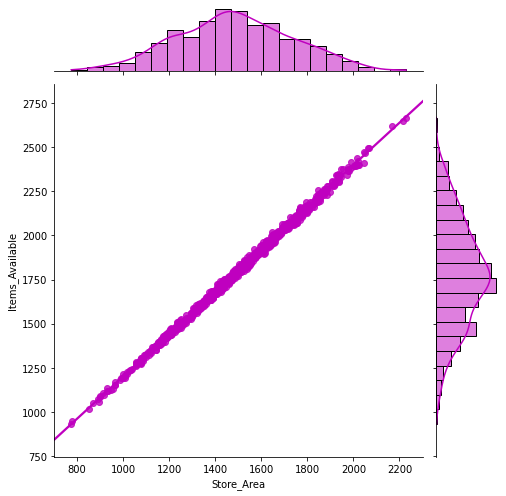

In [ ]:
sns.jointplot(x='Store_Area', y='Items_Available', data=df, kind="reg", truncate=False, color="m", height=7);

Как видно, зависимость линейная: чем больше площадь магазина, тем больше в нем товаров.

## Как связаны размер магазина и количество покупателей?

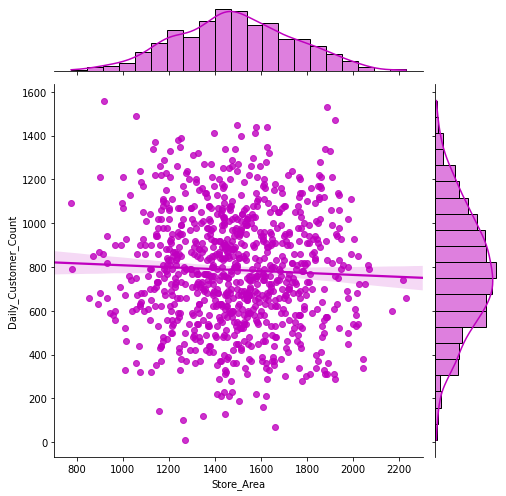

In [ ]:
sns.jointplot(x='Store_Area', y='Daily_Customer_Count', data=df, kind="reg", truncate=False, color="m", height=7);

Как видно, прямой зависимости нет: площадь магазина не оказывает существенного влияние на количество покупателей.

## Зависит ли выручка магазина от его размеров?

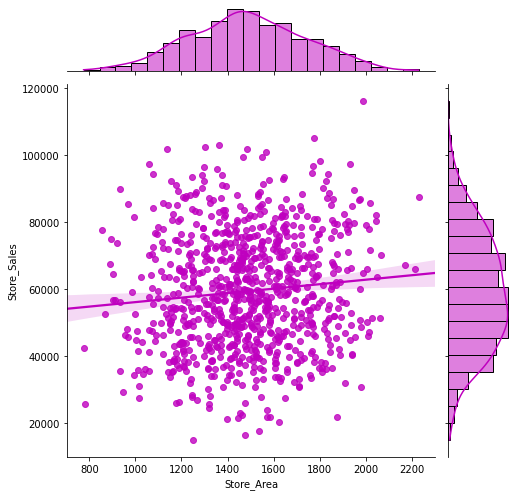

In [ ]:
sns.jointplot(x='Store_Area', y='Store_Sales', data=df, kind="reg", truncate=False, color="m", height=7);

Как видно, покупатели не тратят больше в больших магазинах.

## Возможно, магазины с большим ассортиментом товаров привлекают большее количество покупателей.

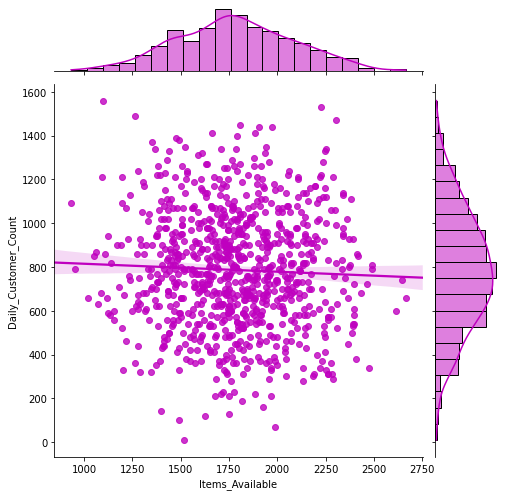

In [ ]:
sns.jointplot(x='Items_Available', y='Daily_Customer_Count', data=df, kind="reg", truncate=False, color="m", height=7);

Зависимости также нет.

# Машинное обучение

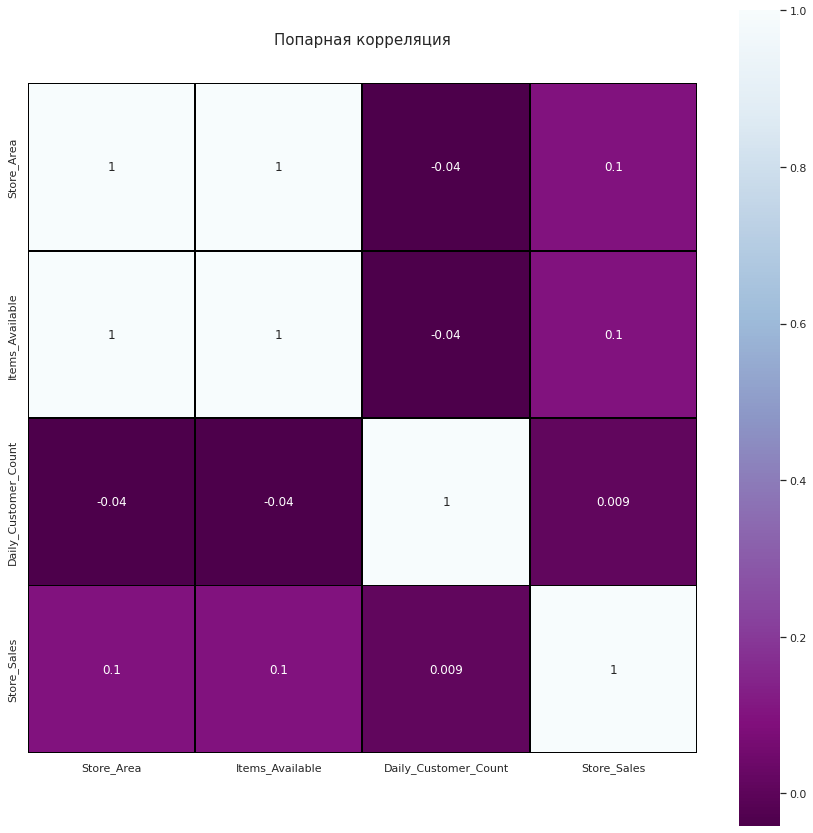

In [51]:
plt.title('Попарная корреляция', y = 1.05, size = 15)
sns.set(rc={"figure.figsize": (15, 15)})
sns.heatmap(df.corr(), annot = True,  fmt='.1g', vmax = 1, cmap = 'BuPu_r', square= True, linewidths=1, linecolor='black')

Так как имеется полная зависимость площади магазина и количества товаров, следует удалить один и з параметров.

In [52]:
df=df.drop('Store_Area',axis=1)

In [53]:
df

,Items_Available,Daily_Customer_Count,Store_Sales
0,1961,530,66490
1,1752,210,39820
2,1609,720,54010
3,1748,620,53730
4,2111,450,46620
...,...,...,...
891,1910,1080,66390
892,1663,850,82080
893,1436,1060,76440
894,1560,770,96610


Кластерный анализ

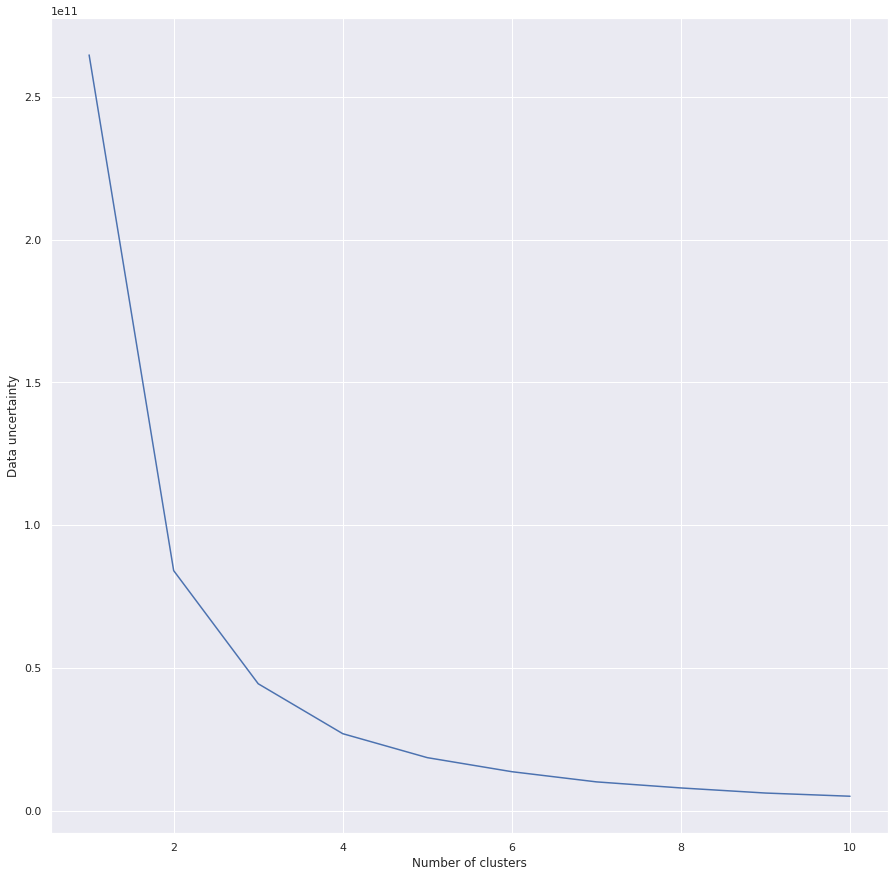

In [54]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit_predict(df_t)
    wcss.append(km.inertia_)
fig, ax = plt.subplots()

ax.plot(range(1,11),wcss)

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Data uncertainty')

plt.show()

Оптимальное количество кластеров - 4

## Поиск и удаление выбросов

### Поиск выбросов

При помощи цикла заменим значения, выходящие за нижнюю и верхнюю границы, на 0.

In [55]:
for x in df.columns:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

Посмотрим количество нулевых значений (выбросов).

In [56]:
df.isnull().sum()

Items_Available         5
Daily_Customer_Count    3
Store_Sales             1
dtype: int64

Количество выбросов незначительное, возможно применить удаление.

Удалим строки, содержащие нулевые значения.

In [57]:
df = df.dropna(axis = 0)

In [58]:
df

,Items_Available,Daily_Customer_Count,Store_Sales
0,1961.0,530.0,66490.0
1,1752.0,210.0,39820.0
2,1609.0,720.0,54010.0
3,1748.0,620.0,53730.0
4,2111.0,450.0,46620.0
...,...,...,...
891,1910.0,1080.0,66390.0
892,1663.0,850.0,82080.0
893,1436.0,1060.0,76440.0
894,1560.0,770.0,96610.0


Сохраняем отдельно целевые значения и отдельные данные без целевых значений.

In [59]:
y=df['Store_Sales']
X=df.drop(['Store_Sales'],axis=1)

Разделение датасета на тренировочный (70%) и тестовый (30%) блоки, зададим параметр random_state.

In [60]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [67]:
models = [RandomForestRegressor(), LinearRegression(),ElasticNet(), KNeighborsRegressor(),xgb.XGBRegressor()]
scores = dict()

for m in models:
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)

    print(f'model: {str(m)}')
    print(f'RMSE: {mean_squared_error(y_test,y_pred)}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print('-'*30, '\n')

model: RandomForestRegressor()
RMSE: 377714696.5712183
MAE: 16175.298533083647
------------------------------ 

model: LinearRegression()
RMSE: 302246027.27518773
MAE: 14375.071102373046
------------------------------ 

model: ElasticNet()
RMSE: 302246040.32730937
MAE: 14375.07146052026
------------------------------ 

model: KNeighborsRegressor()
RMSE: 356137601.4831461
MAE: 15639.61797752809
------------------------------ 

[14:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model: XGBRegressor()
RMSE: 321366782.9228621
MAE: 14892.364685744382
------------------------------ 



Полученная ошибка около 25% от средних значений. Для повышения результата требуется больше данных.